In [1]:
from fenics import *
import mshr
import numpy as np
import matplotlib.pyplot as plt
from egfcore import *
from utils import *

set_log_level(30)
%matplotlib widget

In [2]:
class Simulator:
    
    def __init__(self, meshDensity):
        self.mesh = IntervalMesh(meshDensity,0,1) # (meshDensity = N_sensors) =  # of positions at which the problem is discretized on a unit interval
        mesh_dict = {"X": self.mesh.coordinates()}
        scipy.io.savemat("mesh.mat", mesh_dict)
        self.V = FunctionSpace(self.mesh, 'P', 2)
        
        V = FunctionSpace(self.mesh,'P',1)
        u = TestFunction(V)
        temp = assemble(u*dx)
        self.meshweights = (temp.get_local()[vertex_to_dof_map(V)]).reshape(-1,1)
        
        
    def boundaryConditions(self):
        """
        Define homogeneous Dirichlet Boundary conditions for the problem
        """
        def boundary(x, on_boundary):
            return on_boundary
        
        u_D = Constant(0)
        bc = DirichletBC(self.V, u_D, boundary)
        
        return bc
        
    def forcing(self, fvals):
        V = FunctionSpace(self.mesh, 'P', 1)
        f = Function(V)
        d2v = dof_to_vertex_map(V)
        f.vector()[:] = fvals[d2v]
        return f
        
    def solve(self, forcing, noise_level = None, param = None):
        """
        Given a (N_sensors x 1) forcing vector, solve the a 1D Poisson problem on a unit interval.
        """
        N = np.shape(self.mesh.coordinates())[0]
        
        f = self.forcing(forcing)      
        bc = self.boundaryConditions()

        u = TrialFunction(self.V)
        v = TestFunction(self.V)
        
        airy = Expression('K*K*x[0]', K = param, degree = 2)
        a = (-dot(grad(u), grad(v)) - airy*u*v)* dx
        L = f*v*dx
        u = Function(self.V)
        solve(a == L, u, bc)

        solution = u.compute_vertex_values(self.mesh)

        if noise_level is not None:
            noise =  noise_level*np.random.normal(0,np.abs(solution.mean()),solution.shape)
            solution += noise

        return solution

In [ ]:
%%time
add_noise = False
noise_level = 0.1

# paramSet = np.array([[1.0], [2.0], [3.0], [2.5]])
paramSet = np.array([[1.0], [5.0], [10.0], [7.0]])

meshDensity = 2000
sigma = 0.005
rank = 100
nSamples = rank

Sim = Simulator(meshDensity)
models = []
for i, params in enumerate(paramSet):

    np.random.seed(42)

    print(f"Airy (Theta = $ {params[0]}) | Method: Randomized SVD | meshDensity: {meshDensity}, sigma: {sigma}, nSamples: {nSamples}, rank: {rank}, Noise: {add_noise}")


    meshweights = Sim.meshweights

    # Generate an forcing and output ensemble by simulating Poisson problem with FENICS.
    forcing = sampleforcing(sigma, nSamples)
    solution = np.zeros(forcing.shape)
    for i in range(solution.shape[1]):
        if add_noise:
            solution[:,i] = Sim.solve(forcing[:,i], noise_level, params[0])
        else:
            solution[:,i] = Sim.solve(forcing[:,i], None, params[0])

    if add_noise:
        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, noise_level, None, None, Sim, verbose = False)
    else:
        model = EGF("randomized-svd", params, rank, Sim.mesh, forcing, solution, None, None, None, Sim, verbose = False)
        
    models.append(model)

Airy (Theta = $ 1.0) | Method: Randomized SVD | meshDensity: 2000, sigma: 0.005, nSamples: 100, rank: 100, Noise: False


In [148]:
# samples = 100 # Compute empirical error for 100 samples but on the same mesh

# empError = computeEmpiricalError(models[0], Sim, sigma, samples)

# print(f"Max error: {np.max(empError)}")
# print(f"Mean error: {np.mean(empError)}")

In [149]:
# samples = 100 # Compute empirical error for 100 samples but on the same mesh

# empError = computeEmpiricalError(models[1], Sim, sigma, samples)

# print(f"Max error: {np.max(empError)}")
# print(f"Mean error: {np.mean(empError)}")

In [5]:
# import scipy
# scipy.io.savemat('airymodes.mat', {'U1': models[0].modeset, 'U2': models[1].modeset, 'U3': models[2].modeset, 'U': models[3].modeset})

In [124]:
k = 8
np.set_printoptions(precision=5, suppress=True)
print(X[:,:k].T @ Z[:,:k])

[[ 0.98975 -0.14273 -0.00468  0.0024  -0.00009  0.00028 -0.00001  0.00006]
 [ 0.14254  0.98529  0.0942  -0.00256  0.00216 -0.00007  0.0003  -0.00001]
 [ 0.00867  0.09388 -0.99316  0.06881 -0.00154  0.00182 -0.00005  0.00028]
 [ 0.00259  0.00349 -0.06875 -0.99616  0.054   -0.00102  0.00155 -0.00004]
 [-0.00033 -0.00218  0.0019   0.05399  0.99755 -0.04439  0.00072 -0.00134]
 [-0.00029 -0.00014  0.00183  0.0012   0.04438  0.9983  -0.03766  0.00054]
 [-0.00005 -0.0003   0.00008  0.00155  0.00082  0.03765  0.99875 -0.03269]
 [-0.00007 -0.00002  0.00029  0.00005  0.00134  0.0006   0.03269  0.99905]]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
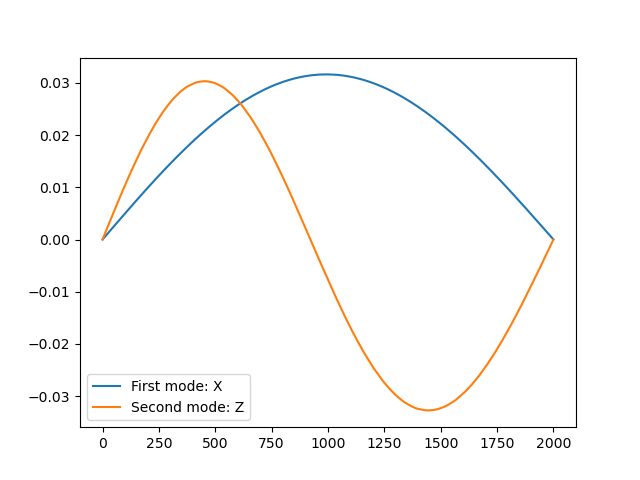

In [144]:
plt.figure()
plt.plot(X[:,0])
plt.plot(Z[:,1])
plt.legend(['First mode: X', 'Second mode: Z'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
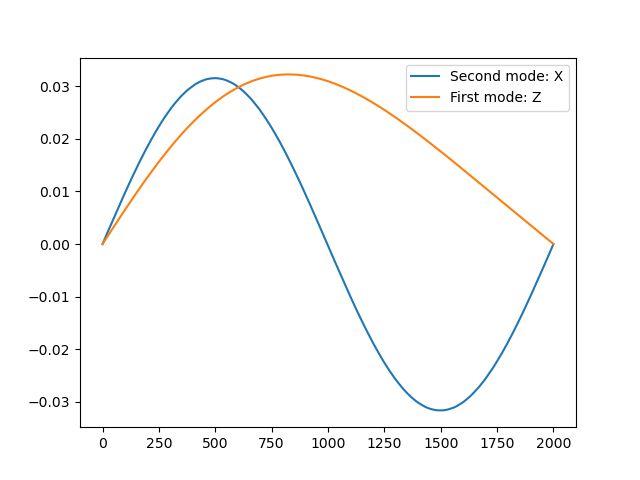

In [145]:
plt.figure()
plt.plot(X[:,1])
plt.plot(Z[:,0])
plt.legend(['Second mode: X', 'First mode: Z'])

In [133]:
X[:,0].T @ Z[:,1]

-0.14272825101601982

In [134]:
Z[:,0].T @ X[:,1]

0.14253757145730894

In [125]:
print(Z[:,:k].T @ X[:,:k])

[[ 0.98975  0.14254  0.00867  0.00259 -0.00033 -0.00029 -0.00005 -0.00007]
 [-0.14273  0.98529  0.09388  0.00349 -0.00218 -0.00014 -0.0003  -0.00002]
 [-0.00468  0.0942  -0.99316 -0.06875  0.0019   0.00183  0.00008  0.00029]
 [ 0.0024  -0.00256  0.06881 -0.99616  0.05399  0.0012   0.00155  0.00005]
 [-0.00009  0.00216 -0.00154  0.054    0.99755  0.04438  0.00082  0.00134]
 [ 0.00028 -0.00007  0.00182 -0.00102 -0.04439  0.9983   0.03765  0.0006 ]
 [-0.00001  0.0003  -0.00005  0.00155  0.00072 -0.03766  0.99875  0.03269]
 [ 0.00006 -0.00001  0.00028 -0.00004 -0.00134  0.00054 -0.03269  0.99905]]


In [73]:
i = 0
j = 1
k = 100
X = models[i].modeset * np.sqrt(models[i].meshweights)
Z = models[j].modeset * np.sqrt(models[j].meshweights)

D1 = X[:,:k].T @ Z[:,:k]
D2 = Z[:,:k].T @ X[:,:k]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
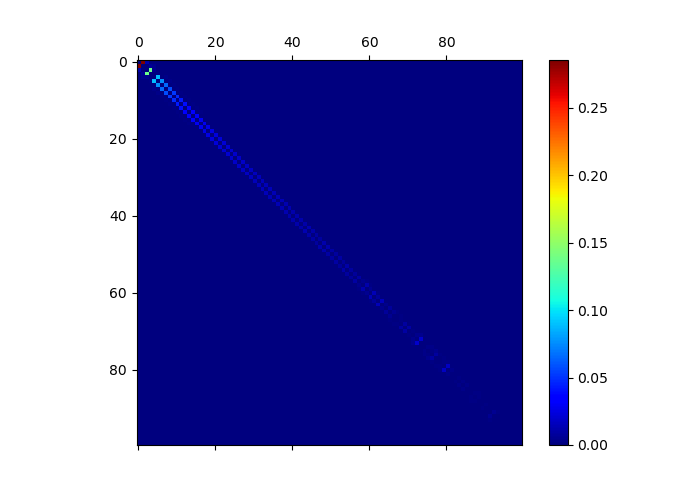

In [82]:
plt.close('all')
plt.figure(figsize = (7,5))
vmin, vmax = None, None
S = np.abs(D1-D2)
# S = D1
surf = plt.matshow(S, 0, cmap = 'jet', vmin = vmin, vmax = vmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(surf)

In [150]:
np.linalg.norm(D1-D2)

0.5408813660687357

In [151]:
np.linalg.norm(D1-D2,'fro')

0.5408813660687357

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
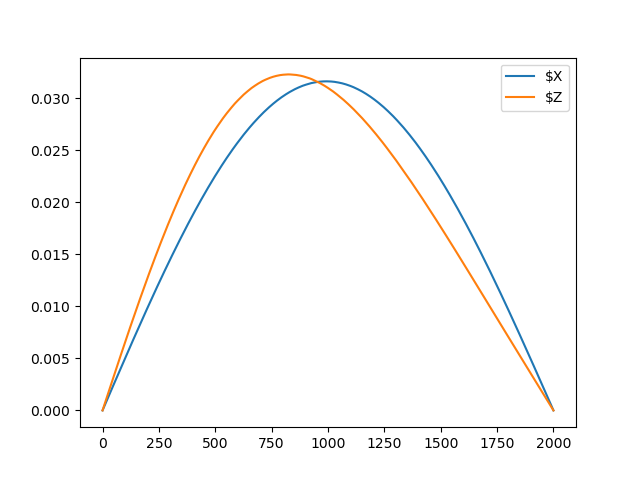

In [34]:
plt.figure()
k = 0
plt.plot(X[:,k])
plt.plot(Z[:,k])
plt.legend(['$X','$Z'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
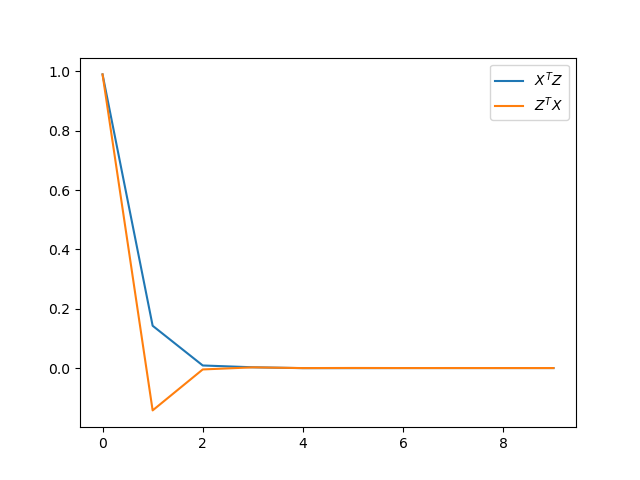

In [56]:
plt.close('all')
plt.figure()
k = 0
plt.plot(D1[:10,k])
plt.plot(D2[:10,k])
plt.legend(['$X^T Z$','$Z^T X$'])

In [9]:
%%time

# Interpolation

print(f"Parameter set: {paramSet}")
interpSet = [models[0], models[1], models[2]]
# interpSet = [models[0], models[2]]


targetParam = paramSet[-1]
targetModel = models[-1]
inputdata = models[-1].forcing #compute_forcing(pSim.mesh, numSteps)
simulator = Sim

interpModel, U_set, _ = model_interp(interpSet, simulator, inputdata, targetParam, verbose = False)
a = compute_interp_coeffs(interpSet, targetParam)

Parameter set: [[ 1.]
 [ 5.]
 [10.]
 [ 7.]]
CPU times: user 635 ms, sys: 165 ms, total: 800 ms
Wall time: 246 ms


Text(0.5, 1.0, 'Coefficients (S)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
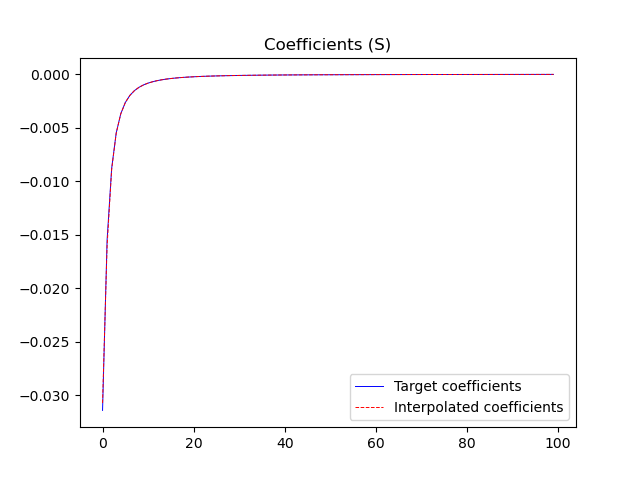

In [7]:
plt.figure()
plt.plot(targetModel.dcoeffs,'b-', linewidth = 0.7, alpha = 1)
plt.plot(interpModel.dcoeffs,'r--', linewidth = 0.7, alpha = 1)
plt.legend(['Target coefficients','Interpolated coefficients'])
plt.title('Coefficients (S)')

Text(0.5, 1.0, 'Interpolated Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
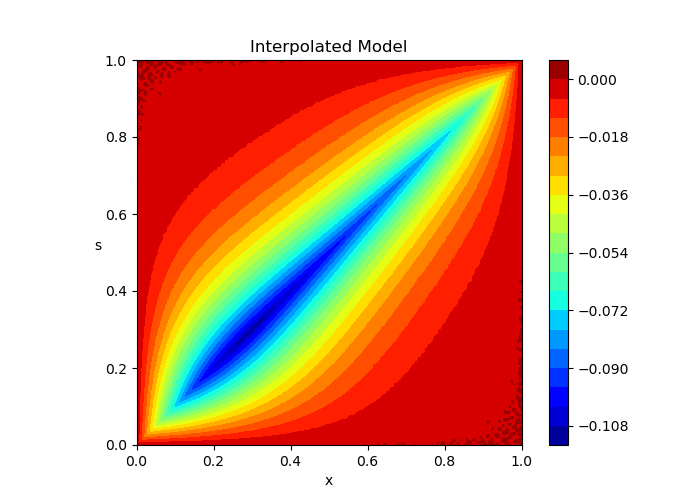

In [8]:
plotGreen1D(interpModel)
plt.title('Interpolated Model')

Text(0.5, 1.0, 'Target Model')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
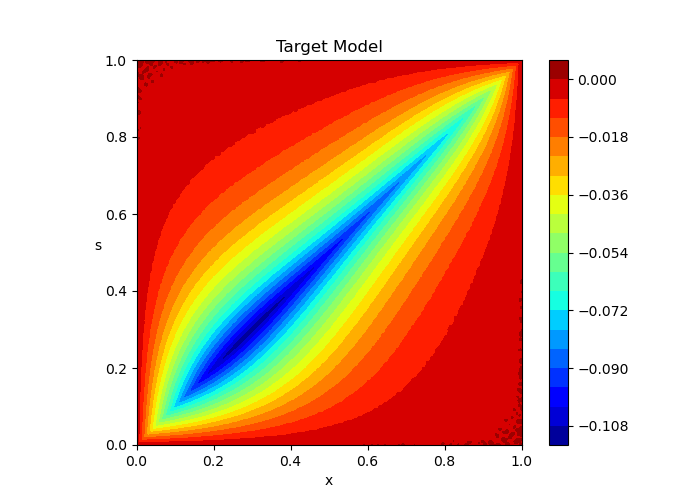

In [9]:
plotGreen1D(targetModel)
plt.title('Target Model')

In [13]:
def computeEmpiricalError(model, Sim, sigma, nSamples, noise_level = None):
    seed = 1
    np.random.seed(1)

    # Generate an forcing and output ensemble for testing
    forcing = sampleforcing(sigma, nSamples, seed)
    solution = np.zeros(forcing.shape)
    for i in range(nSamples):
        if add_noise:
            solution[:,i] = Sim.solve(forcing[:,i], noise_level, model.params[0])
        else:
            solution[:,i] = Sim.solve(forcing[:,i], None, model.params[0])
    
    reconstruction = model.reconstruct_signal(forcing)
    
    error = np.zeros(nSamples)
    for i in range(nSamples):
        V = FunctionSpace(Sim.mesh, 'P', 1)
        d2v = dof_to_vertex_map(V)
        temp = Function(V)
        temp.vector()[:] = np.square(reconstruction[:,i] - solution[:,i])[d2v]
        num = assemble(temp*dx)
        temp.vector()[:] = np.square(solution[:,i])[d2v]
        den = assemble(temp*dx)
        
        error[i] = np.sqrt(num/den)
        
    return error

In [14]:
err = computeEmpiricalError(interpModel, Sim, sigma, nSamples, noise_level = None)
print(f"Max error: {np.max(err)}")
print(f"Mean error: {np.mean(err)}")

Max error: 0.038431178239622756
Mean error: 0.02602855230969605


In [15]:
# Manifold interpolation

computeError(reconstructEGF1D(interpModel), reconstructEGF1D(targetModel))

0.02442034545044335

In [16]:
def plotAiryPaper1(interpSet, interpModel, targetModel, vmin = None, vmax = None):
    domain = interpModel.mesh.coordinates()
    x, s = np.meshgrid(domain,domain)
    fig = plt.figure(figsize = (17,4))
    
    plt.tight_layout()
    grid = plt.GridSpec(1, 6, wspace = 0.2, hspace = 0.3)
    plt.subplots_adjust(left = 0.1, right = 0.9)

    plt.subplot(grid[0, :2])
    G = reconstructEGF1D(interpSet[0])
    
    levels = np.linspace(vmin, vmax, 30)
    surf = plt.contourf(x, s, G, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(surf,fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 10))
    plt.xlabel('x')
    plt.ylabel('s', rotation='horizontal', labelpad=5)
    plt.title(f"Interpolant ($\\theta = {interpSet[0].params[0]}$)")
    plt.title('A',loc ='left', weight = 'bold', size = 12)
    
    plt.subplot(grid[0, 2:4])
    G = reconstructEGF1D(interpSet[1])
    
    levels = np.linspace(vmin, vmax, 30)
    surf = plt.contourf(x, s, G, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(surf,fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 10))
    plt.clim(vmin, vmax) 
    plt.xlabel('x')
    plt.ylabel('s', rotation='horizontal', labelpad=5)
    plt.title(f"Interpolant ($\\theta = {interpSet[1].params[0]}$)")
    plt.title('B',loc ='left', weight = 'bold', size = 12)    
    
    plt.subplot(grid[0, 4:6])
    G = reconstructEGF1D(interpSet[2])
    
    levels = np.linspace(vmin, vmax, 30)
    surf = plt.contourf(x, s, G, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(surf, fraction=0.046, pad=0.04, ticks = np.linspace(vmin, vmax, 10))
    plt.clim(vmin, vmax) 
    plt.xlabel('x')
    plt.ylabel('s', rotation='horizontal', labelpad=5)
    plt.title(f"Interpolant ($\\theta = {interpSet[2].params[0]}$)")
    plt.title('C',loc ='left', weight = 'bold', size = 12)  

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
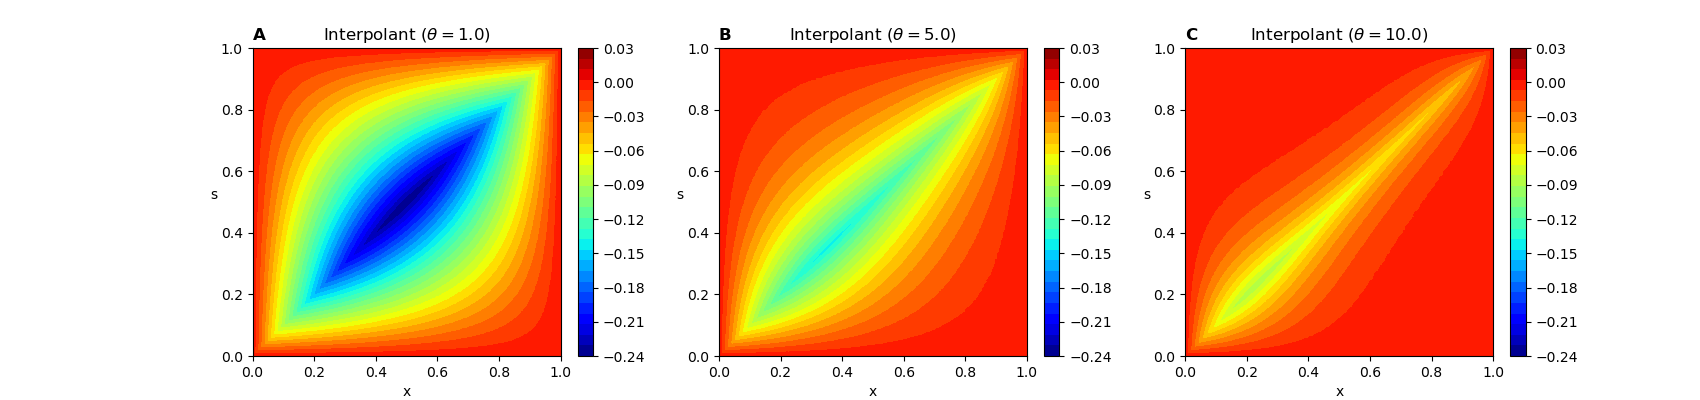

In [17]:
plotAiryPaper1(interpSet,interpModel,targetModel, -0.24, 0.03)

In [18]:
def plotAiryPaper2(interpSet, interpModel, targetModel, vmin = None, vmax = None):
    domain = interpModel.mesh.coordinates()
    x, s = np.meshgrid(domain,domain)
    fig = plt.figure(figsize = (12,4))
    
    plt.tight_layout()
    grid = plt.GridSpec(1, 2, wspace = 0.2, hspace = 0.3, left = 0.01)
    plt.subplots_adjust(left = 0.1, right = 0.9)
    
    plt.subplot(grid[0,0])
    G = reconstructEGF1D(interpModel)
    
    levels = np.linspace(vmin, vmax, 30)
    surf = plt.contourf(x, s, G, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(surf, ticks = np.linspace(vmin, vmax, 10))
    plt.clim(vmin, vmax) 
    plt.xlabel('x')
    plt.ylabel('s', rotation='horizontal', labelpad=5)
    plt.title(f"Interp. Model ($\\theta = {interpModel.params[0]}$)")
    plt.title('D',loc ='left', weight = 'bold', size = 12)
    
    plt.subplot(grid[0, 1])
    G = reconstructEGF1D(targetModel)
    
    levels = np.linspace(vmin, vmax, 30)
    plt.gca().set_aspect('equal', adjustable = 'box', anchor = (0,0))
    surf = plt.contourf(x, s, G, levels = levels, cmap = 'jet', vmin = vmin, vmax = vmax)
    plt.colorbar(surf, ticks = np.linspace(vmin, vmax, 10), panchor = False)
    plt.xlabel('x')
    plt.ylabel('s', rotation='horizontal', labelpad=5)
    plt.title(f"Target Model ($\\theta = {targetModel.params[0]}$)")
    plt.title('E',loc ='left', weight = 'bold', size = 12)    

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
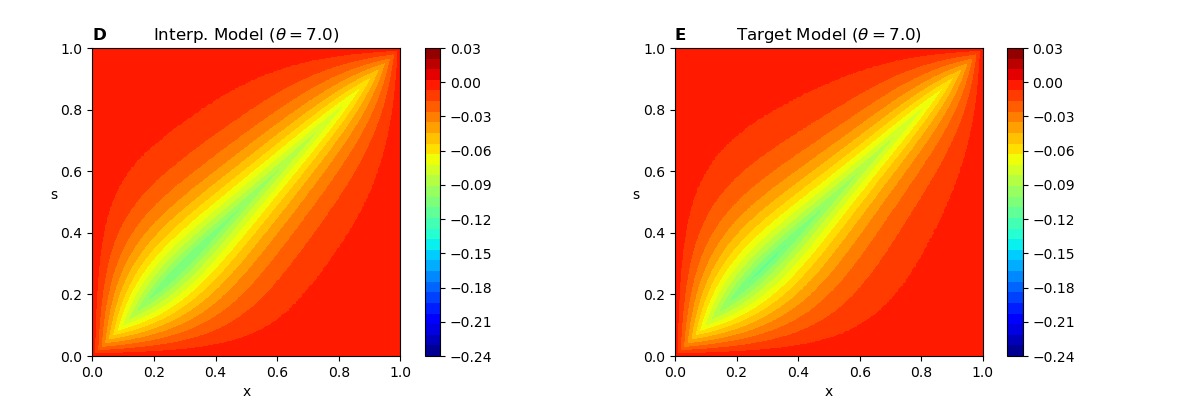

In [19]:
plotAiryPaper2(interpSet,interpModel,targetModel, -0.24, 0.03)